In [1]:
from pandas import read_csv, DataFrame, to_numeric
import numpy as np
import re
import pandas as pd
from matplotlib.pyplot import figure, show, savefig
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose

from dslab_functions import mvi_by_dropping, mvi_by_filling
from dslab_functions import plot_bar_chart

from dslab_functions import get_variable_types, run_NB, run_KNN, CLASS_EVAL_METRICS, plot_multibar_chart

def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    eval_NB: dict[str, float] | None = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] | None = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_NB[met], eval_KNN[met]]
    return eval

# read file
filename = "class_credit_score.csv"
file_tag = "class_credit_score"
data : DataFrame = read_csv('class_credit_score.csv')
print(data.shape)

(100000, 28)


# VARIABLE ENCODING

- ID: drop
- Binary vars: ole              
- Month: ole         
- Name: drop			
- SSN: drop						
- Occupation: oebt					
- Type_of_Loan:	dummy, other					
- CreditMix: ole					
- Credit_History_Age: other						
- Payment_Behaviour: oebt			

In [2]:
def data_cleaning(df: DataFrame):
    variable_types: dict[str, list] = get_variable_types(df)

    # Age
    df['Age'] = to_numeric(df['Age'], errors='coerce')
    df['Age'] = np.where((df['Age'].isnull()) | (df['Age'] < 0) | (df['Age'] > 120), np.nan, df['Age'])
    
    # Monthly Balance
    df['MonthlyBalance'] = df['MonthlyBalance'].replace(-3.33333E+26, np.nan)
    
    # Num_Bank_Accounts
    df['Num_Bank_Accounts'] = np.where(df['Num_Bank_Accounts'] < 0, np.nan, df['Num_Bank_Accounts'])
    
    # NumofLoan
    df['NumofLoan'] = np.where(df['NumofLoan'] < 0, np.nan, df['NumofLoan'])
    
    # Delay_from_due_date
    df['Delay_from_due_date'] = np.where(df['Delay_from_due_date'] < 0, np.nan, df['Delay_from_due_date'])
    
    # NumofDelayedPayment
    df['NumofDelayedPayment'] = np.where(df['NumofDelayedPayment'] < 0, np.nan, df['NumofDelayedPayment'])
    
    # ChangedCreditLimit
    df['ChangedCreditLimit'] = np.where(df['ChangedCreditLimit'] < 0, np.nan, df['ChangedCreditLimit'])

data_cleaning(data)

columns = ['ID', 'Customer_ID', 'Name', 'SSN']
existing_columns = [col for col in columns if col in data.columns]
if len(existing_columns) > 0:
    data.drop(columns = existing_columns, inplace = True)
#data.dropna()

vars: dict[str, list] = get_variable_types(data)
for v in vars["symbolic"]:
    print(v, data[v].unique())

Month ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']
Occupation ['Scientist' nan 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']
Type_of_Loan ['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan'
 'Credit-Builder Loan' 'Auto Loan, Auto Loan, and Not Specified' ...
 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan'
 'Payday Loan, Student Loan, Mortgage Loan, and Not Specified'
 'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan']
CreditMix [nan 'Good' 'Standard' 'Bad']
Credit_History_Age ['22 Years and 1 Months' nan '22 Years and 3 Months'
 '22 Years and 4 Months' '22 Years and 5 Months' '22 Years and 6 Months'
 '22 Years and 7 Months' '26 Years and 7 Months' '26 Years and 8 Months'
 '26 Years and 9 Months' '26 Years and 10 Months' '26 Years and 11 Months'
 '27 Years and 0 Months' '27 Years and 1 Months' '27

In [3]:
vars: dict[str, list] = get_variable_types(data)
print(vars["binary"])
print(vars["symbolic"])
print(vars["numeric"])

vars_num: list[str] = vars["numeric"]
print(data.shape)
print(vars_num)
data.describe()

['Credit_Score']
['Month', 'Occupation', 'Type_of_Loan', 'CreditMix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour']
['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'NumofLoan', 'Delay_from_due_date', 'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'OutstandingDebt', 'CreditUtilizationRatio', 'TotalEMIpermonth', 'Amountinvestedmonthly', 'MonthlyBalance']
(100000, 24)
['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'NumofLoan', 'Delay_from_due_date', 'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'OutstandingDebt', 'CreditUtilizationRatio', 'TotalEMIpermonth', 'Amountinvestedmonthly', 'MonthlyBalance']


,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,NumofLoan,Delay_from_due_date,NumofDelayedPayment,ChangedCreditLimit,NumCreditInquiries,OutstandingDebt,CreditUtilizationRatio,TotalEMIpermonth,Amountinvestedmonthly,MonthlyBalance
count,92377.000000,1.000000e+05,84998.000000,99979.000000,100000.00000,100000.000000,96124.000000,99409.000000,92354.000000,96323.000000,98035.000000,100000.000000,100000.000000,100000.000000,95521.000000,98791.000000
mean,33.322580,1.764157e+05,4194.170850,17.095080,22.47443,72.466040,7.163622,21.207245,31.150519,10.599042,27.754251,1426.220376,32.285173,1403.118217,637.412998,402.551258
std,10.797911,1.429618e+06,3183.686167,117.416871,129.05741,466.422621,60.314923,14.794693,226.802173,6.639966,193.177339,1155.129026,5.116875,8306.041270,2043.319327,213.925499
min,14.000000,7.005930e+03,303.645417,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230000,20.000000,0.000000,0.000000,0.007760
25%,24.000000,1.945750e+04,1625.568229,3.000000,4.00000,8.000000,2.000000,10.000000,9.000000,5.570000,3.000000,566.072500,28.052567,30.306660,74.534002,270.106630
50%,33.000000,3.757861e+04,3093.745000,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,9.520000,6.000000,1166.155000,32.305784,69.249473,135.925681,336.731225
75%,42.000000,7.279092e+04,5957.448333,7.000000,7.00000,20.000000,5.000000,28.000000,18.000000,15.010000,9.000000,1945.962500,36.496663,161.224249,265.731733,470.262938
max,118.000000,2.419806e+07,15204.633330,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,82331.000000,10000.000000,1602.040519


MVI

In [4]:
df: DataFrame = mvi_by_dropping(data, min_pct_per_variable=0.7, min_pct_per_record=0.9)
df.shape

(92741, 24)

In [5]:
df: DataFrame = mvi_by_filling(df, strategy="frequent")
df.head(10)
df.shape

(92741, 24)

### BINARY

In [6]:
# encode binary
def encoding_credit_score(data: DataFrame): 
    df2: DataFrame = data
    df2["Credit_Score"] = data.apply(lambda x: 1 if x["Credit_Score"] == "Good" else 0 if x["Credit_Score"] == "Poor" else None, axis=1)
    return df2


### SYMBOLIC

In [7]:
#encode symbolic
def encoding_credit_age(data: DataFrame):
    df2: DataFrame = data

    def convert_to_int(value):
        try:
            if re.findall(r'\d+', str(value)) == []:
                return None
            yearsToMonth = int(re.findall(r'\d+', str(value))[0]) * 12
            sumMonths = yearsToMonth + int(re.findall(r'\d+', str(value))[1])
          
            return sumMonths
        except (ValueError, TypeError):
            return None  # Or any other appropriate value indicating the failure to convert
    df2["Credit_History_Age"] = data.apply(lambda x: convert_to_int(x["Credit_History_Age"]), axis=1)
     
    return df2

def encoding_ssn(data: DataFrame):
    
    def convert_to_float(value):
        try:
            return float(re.sub(r'\D+', '', str(value)))
        except (ValueError, TypeError):
            return None  # Or any other appropriate value indicating the failure to convert
        
    df2: DataFrame = data
    df2["SSN"] = data.apply(lambda x: convert_to_float(x["SSN"]), axis=1)
    return df2

def encoding_month(data: DataFrame): 
    df2: DataFrame = data
    df2["Month"] = data.apply(lambda x: 1 if x["Month"] == "January" else 2 if x["Month"] == "February" else 3 if x["Month"] == "March"
                              else 4 if x["Month"] == "April" else 5 if x["Month"] == "May" else 6 if x["Month"] == "June" else 7 if
                              x["Month"] == "July" else 8 if x["Month"] == "August" else None, axis=1)
    return df2

def encoding_creditmix(data: DataFrame): 
    df2: DataFrame = data
    df2["CreditMix"] = data.apply(lambda x: 2 if x["CreditMix"] == "Good" 
                                  else 1 if x["CreditMix"] == "Standard" else 0 if x["CreditMix"] == "Bad" else None, axis=1)
    return df2

def encoding_payment_min(data: DataFrame):
    df2: DataFrame = data
    df2["Payment_of_Min_Amount"] = data.apply(lambda x: 2 if x["Payment_of_Min_Amount"] == "NM" 
                                  else 1 if x["Payment_of_Min_Amount"] == "Yes" else 0 if x["Payment_of_Min_Amount"] == "No" else None, axis=1)
    return df2

def encoding_payment_behaviour(data: DataFrame):
    df2: DataFrame = data
    df2["Payment_Behaviour"] = data.apply(lambda x: 1 if x["Payment_Behaviour"] == "Low_spent_Small_value_payments" 
                                  else 2 if x["Payment_Behaviour"] == "Low_spent_Medium_value_payments" else 3 
                                  if x["Payment_Behaviour"] == "Low_spent_Large_value_payments" else 4 if 
                                  x["Payment_Behaviour"] == "High_spent_Small_value_payments" 
                                  else 5 if x["Payment_Behaviour"] == "High_spent_Medium_value_payments" else 6 
                                  if x["Payment_Behaviour"] == "High_spent_Large_value_payments" else None, axis=1)
    return df2

def encoding_loans(data: DataFrame):
    df2: DataFrame = data
    for idx, x in df2["Type_of_Loan"].items():
        try:
            #splits the different loans of the string
            split = re.split(r', and |, ', x)  
        except (ValueError, TypeError):
            continue
        for n in split:
            #if it isnt in the columns, creates a new one with 0 on all cells
            if n not in df2.columns:
                df2[n] = 0
            else:
            #otherwhise add 1 to the cell
                df2.at[idx, n] += 1
    df2.drop(columns = ['Type_of_Loan'], inplace = True)
    return df2

def encoding_occupations(data: DataFrame):
    df2: DataFrame = data
    df2["Occupation"] = data.apply(lambda x: 1 if x["Occupation"] == "Doctor" 
                                  else 2 if x["Occupation"] == "Architect" else 3 
                                  if x["Occupation"] == "Engineer"  else 4 if x["Occupation"] == "Mechanic" 
                                  else 5 if x["Occupation"] == "Developer"  else 6 
                                  if x["Occupation"] == "Scientist"  else 7 if x["Occupation"] == "Teacher" else
                                  8 if x["Occupation"] == "Accountant" else 9 if x["Occupation"] == "Manager" else
                                  10 if x["Occupation"] == "Entrepreneur" else 11 if x["Occupation"] == "Lawyer" else
                                  12 if x["Occupation"] == "Journalist" else 13 if x["Occupation"] == "Writer" else
                                  14 if x["Occupation"] == "Media_Manager" else 15 if x["Occupation"] == "Musician" else
                                  None, axis=1)
    return df2

df = encoding_credit_age(df)
#data = encoding_ssn(data)
df = encoding_month(df)
df = encoding_creditmix(df)
df = encoding_payment_min(df)
df = encoding_payment_behaviour(df)
df = encoding_loans(df)
df = encoding_occupations(df)
df = df[[col for col in df.columns if col != 'Credit_Score'] + ['Credit_Score']]
df = encoding_credit_score(df)

vars: dict[str, list] = get_variable_types(df)
print(vars["symbolic"])
print(vars["binary"])
print(vars["numeric"])


[]
['Credit_Score']
['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'NumofLoan', 'Delay_from_due_date', 'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'OutstandingDebt', 'CreditUtilizationRatio', 'TotalEMIpermonth', 'Amountinvestedmonthly', 'MonthlyBalance', 'Month', 'Occupation', 'CreditMix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Auto Loan', 'Credit-Builder Loan', 'Personal Loan', 'Home Equity Loan', 'Not Specified', 'Mortgage Loan', 'Student Loan', 'Debt Consolidation Loan', 'Payday Loan']


# MISSING VALUES IMPUTATION

Dataset nr records=92741 nr variables=32


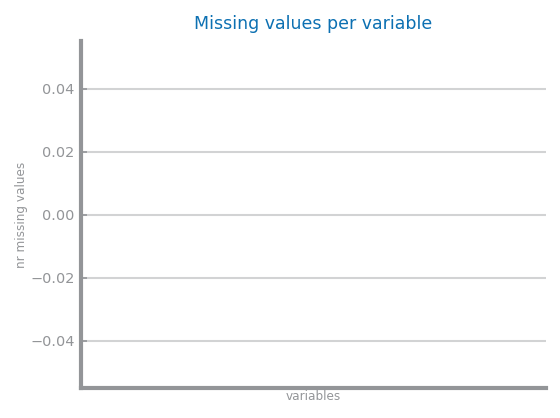

In [8]:
print(f"Dataset nr records={df.shape[0]}", f"nr variables={df.shape[1]}")

mv: dict[str, int] = {}
figure()
for var in df:
    nr: int = df[var].isna().sum()
    if nr > 0:
        mv[var] = nr

plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
show()

In [9]:
df.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,NumofLoan,Delay_from_due_date,NumofDelayedPayment,ChangedCreditLimit,...,Auto Loan,Credit-Builder Loan,Personal Loan,Home Equity Loan,Not Specified,Mortgage Loan,Student Loan,Debt Consolidation Loan,Payday Loan,Credit_Score
count,92741.000000,9.274100e+04,92741.000000,92741.000000,92741.000000,92741.000000,92741.000000,92741.000000,92741.000000,92741.000000,...,92741.000000,92741.000000,92741.000000,92741.000000,92741.000000,92741.000000,92741.000000,92741.000000,92741.000000,92741.000000
mean,33.235646,1.764248e+05,4030.298817,17.097325,22.267746,73.394540,7.039281,21.376101,30.287295,10.635711,...,0.388016,0.412795,0.398141,0.399877,0.498593,0.398303,0.398572,0.396567,0.415577,0.705621
std,10.426180,1.435510e+06,2985.071995,116.981298,127.918948,470.387039,58.839181,14.837007,220.759377,6.564751,...,0.643963,0.671407,0.650749,0.651631,0.663093,0.646786,0.654237,0.649240,0.669543,0.455766
min,14.000000,7.005930e+03,303.645417,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,1.930321e+04,1746.922500,4.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.770000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,3.722724e+04,3076.995833,6.000000,6.000000,14.000000,3.000000,18.000000,14.000000,9.580000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,41.000000,7.224102e+04,5428.120000,8.000000,7.000000,21.000000,5.000000,28.000000,18.000000,14.880000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,118.000000,2.419806e+07,15204.633330,1798.000000,1499.000000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,1.000000


# MVI APPROACH

(62136, 31) (62136,) (62136, 32)


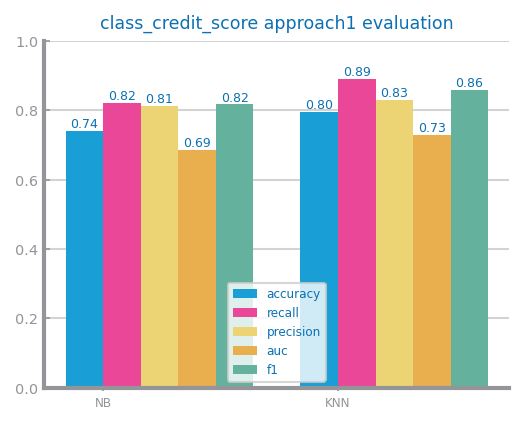

In [10]:
target = 'Credit_Score'
X, y = df.loc[:, df.columns != 'Credit_Score'], df['Credit_Score']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)
print(Xtrain.shape, Ytrain.shape, train.shape)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} approach1 evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/missing_values/eval_approach1.png")
show()

df.to_csv(f"data/{file_tag}/data_preparation/missing_values/eval_approach1.csv", index=False)

# OUTLIERS

### DROP OUTLIERS

In [11]:
from pandas import read_csv, DataFrame, Series

from dslab_functions import NR_STDEV, get_variable_types, determine_outlier_thresholds_for_var

file_tag = "class_credit_score"
data : DataFrame = read_csv('data/class_credit_score/data_preparation/missing_values/eval_approach1.csv')
print(f"Original data: {data.shape}")
data_cleaning(data)

n_std: int = NR_STDEV
#numeric_vars: list[str] = get_variable_types(data)["numeric"]
numeric_vars: list[str] = vars_num
if numeric_vars is not None:
    df: DataFrame = data.copy(deep=True)
    summary5: DataFrame = data[numeric_vars].describe()
    for var in numeric_vars:
        top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
            summary5[var], True, 3
        )
        outliers: Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
        df.drop(outliers.index, axis=0, inplace=True)
    df.to_csv(f"data/{file_tag}/data_preparation/outliers/drop_outliers.csv", index=False)
    print(f"Data after dropping outliers: {df.shape}")
else:
    print("There are no numeric variables")
    
df.describe()

Original data: (92741, 32)
Data after dropping outliers: (77801, 32)


,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,NumofLoan,Delay_from_due_date,NumofDelayedPayment,ChangedCreditLimit,...,Auto Loan,Credit-Builder Loan,Personal Loan,Home Equity Loan,Not Specified,Mortgage Loan,Student Loan,Debt Consolidation Loan,Payday Loan,Credit_Score
count,77801.000000,7.780100e+04,77801.000000,77801.000000,77801.000000,77801.000000,77801.000000,77801.000000,77801.000000,77801.000000,...,77801.000000,77801.000000,77801.000000,77801.000000,77801.000000,77801.000000,77801.000000,77801.000000,77801.000000,77801.000000
mean,33.164124,5.071121e+04,3814.993888,5.963882,6.879217,18.866313,3.681238,21.546587,13.998213,10.661018,...,0.392090,0.418195,0.400805,0.402476,0.499145,0.402964,0.403671,0.401769,0.420509,0.702497
std,10.411654,1.058559e+05,2664.142156,11.514583,18.407507,63.550423,3.396737,14.793236,13.962665,6.482372,...,0.647124,0.674676,0.650872,0.654412,0.665339,0.648269,0.659441,0.653304,0.673065,0.457162
min,14.000000,7.005930e+03,303.645417,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,1.907263e+04,1720.386667,4.000000,4.000000,8.000000,2.000000,10.000000,10.000000,5.850000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,3.587336e+04,3076.995833,6.000000,5.000000,14.000000,3.000000,18.000000,14.000000,9.580000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,41.000000,6.848916e+04,5189.247500,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,14.990000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,56.000000,4.442389e+06,12962.260000,368.000000,403.000000,1482.000000,182.000000,65.000000,683.000000,30.320000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,1.000000


(52126, 31) (52126,) (52126, 32)


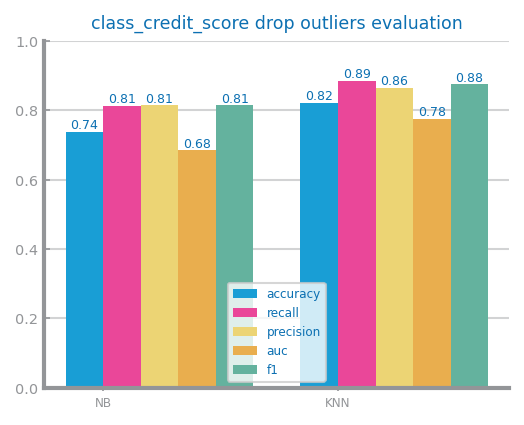

In [12]:
target = 'Credit_Score'
X, y = df.loc[:, df.columns != 'Credit_Score'], df['Credit_Score']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)
print(Xtrain.shape, Ytrain.shape, train.shape)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} drop outliers evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/outliers/drop_outliers_eval_approach1.png")
show()

### REPLACING OUTLIERS WITH FIXED VALUES

In [13]:
file_tag = "class_credit_score"
data : DataFrame = read_csv('data/class_credit_score/data_preparation/missing_values/eval_approach1.csv')
print(f"Original data: {data.shape}")
data_cleaning(data)

numeric_vars: list[str] = vars_num
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var], True, 3)
        median: float = df[var].median()
        df[var] = df[var].apply(lambda x: median if x > top or x < bottom else x)
    df.to_csv(f"data/{file_tag}/data_preparation/outliers/replacing_outliers.csv", index=False)
    print("Data after replacing outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")

Original data: (92741, 32)
Data after replacing outliers: (92741, 32)
                Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count  92741.000000   9.274100e+04           92741.000000       92741.000000   
mean      33.228529   5.344143e+04            3875.919347           5.898308   
std       10.400976   1.067255e+05            2735.410625          11.237993   
min       14.000000   7.005930e+03             303.645417           0.000000   
25%       25.000000   1.930321e+04            1746.922500           4.000000   
50%       33.000000   3.722724e+04            3076.995833           6.000000   
75%       41.000000   7.101044e+04            5229.463333           7.000000   
max       56.000000   4.442389e+06           12962.260000         368.000000   

       Num_Credit_Card  Interest_Rate     NumofLoan  Delay_from_due_date  \
count     92741.000000   92741.000000  92741.000000         92741.000000   
mean          6.821298      18.749712      3.637550      

(62136, 31) (62136,) (62136, 32)


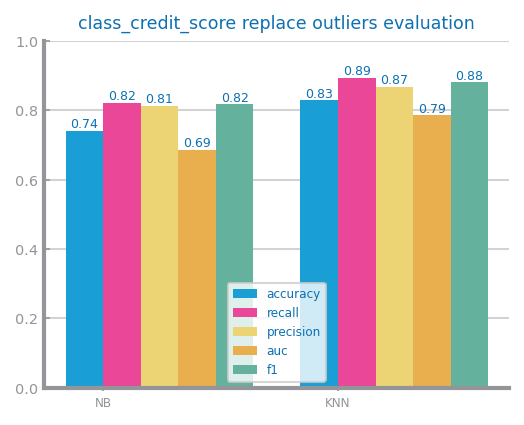

In [14]:
target = 'Credit_Score'
X, y = df.loc[:, df.columns != 'Credit_Score'], df['Credit_Score']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)
print(Xtrain.shape, Ytrain.shape, train.shape)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} replace outliers evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/outliers/replacing_outliers_eval_approach2.png")
show()

### TRUNCATING OUTLIERS

In [15]:

file_tag = "class_credit_score"
data : DataFrame = read_csv('data/class_credit_score/data_preparation/missing_values/eval_approach1.csv')
print(f"Original data: {data.shape}")
data_cleaning(data)

numeric_vars: list[str] = vars_num
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var], True, 3)
        df[var] = df[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    df.to_csv(f"data/{file_tag}/data_preparation/outliers/truncate_outliers.csv", index=False)
    print("Data after truncating outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")

Original data: (92741, 32)
Data after truncating outliers: (92741, 32)
                Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count  92741.000000   9.274100e+04           92741.000000       92741.000000   
mean      33.231587   9.035293e+04            4015.346540           9.704502   
std       10.405540   4.158499e+05            2936.286309          38.608200   
min       14.000000   7.005930e+03             303.645417           0.000000   
25%       25.000000   1.930321e+04            1746.922500           4.000000   
50%       33.000000   3.722724e+04            3076.995833           6.000000   
75%       41.000000   7.224102e+04            5428.120000           8.000000   
max       64.514184   4.482954e+06           12985.514803         368.041219   

       Num_Credit_Card  Interest_Rate     NumofLoan  Delay_from_due_date  \
count     92741.000000   92741.000000  92741.000000         92741.000000   
mean         13.295640      40.964789      4.375422     

(62136, 31) (62136,) (62136, 32)


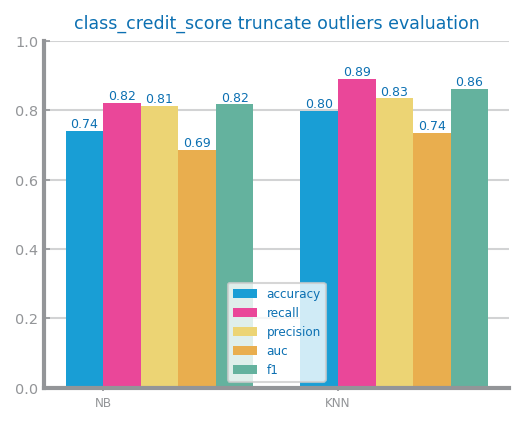

In [16]:

target = 'Credit_Score'
X, y = df.loc[:, df.columns != 'Credit_Score'], df['Credit_Score']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)
print(Xtrain.shape, Ytrain.shape, train.shape)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} truncate outliers evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/outliers/truncate_outliers_eval_approach3.png")
show()


# SCALING

### Z-SCORE

In [17]:
from pandas import read_csv, DataFrame, Series
from sklearn.preprocessing import StandardScaler

file = "class_credit_score"
data : DataFrame = read_csv('data/class_credit_score/data_preparation/outliers/replacing_outliers.csv')

target = "Credit_Score"
vars: list[str] = data.columns.to_list()
target_data: Series = data.pop(target)

transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(data)
df_zscore = DataFrame(transf.transform(data), index=data.index)
df_zscore[target] = target_data
df_zscore.columns = vars
df_zscore.to_csv(f"data/{file}/data_preparation/scaling/zscore.csv", index=False)

(62136, 31) (62136,) (62136, 32)


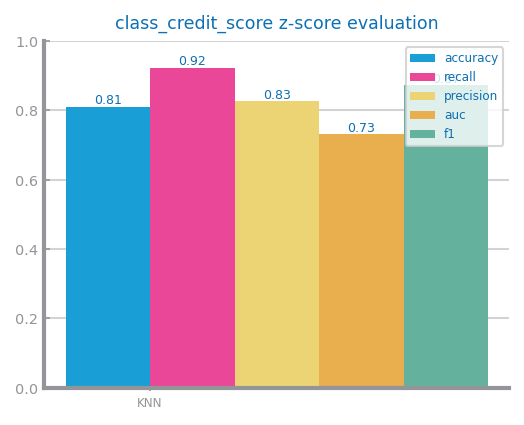

In [18]:
def evaluate_knn(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    #eval_NB: dict[str, float] | None = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] | None = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = eval_KNN[met]
    return eval


target = 'Credit_Score'
X, y = df_zscore.loc[:, df_zscore.columns != 'Credit_Score'], df_zscore['Credit_Score']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)
print(Xtrain.shape, Ytrain.shape, train.shape)

figure()
eval: dict[str, list] = evaluate_knn(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["KNN"], eval, title=f"{file_tag} z-score evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/scaling/zscore.png")
show()

### MINMAX SCALER

In [19]:
from sklearn.preprocessing import MinMaxScaler

file = "class_credit_score"
data : DataFrame = read_csv('data/class_credit_score/data_preparation/outliers/replacing_outliers.csv')

target = "Credit_Score"
vars: list[str] = data.columns.to_list()
target_data: Series = data.pop(target)

transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_minmax = DataFrame(transf.transform(data), index=data.index)
df_minmax[target] = target_data
df_minmax.columns = vars
df_minmax.to_csv(f"data/{file}/data_preparation/scaling/minmax.csv", index=False)

(62136, 31) (62136,) (62136, 32)


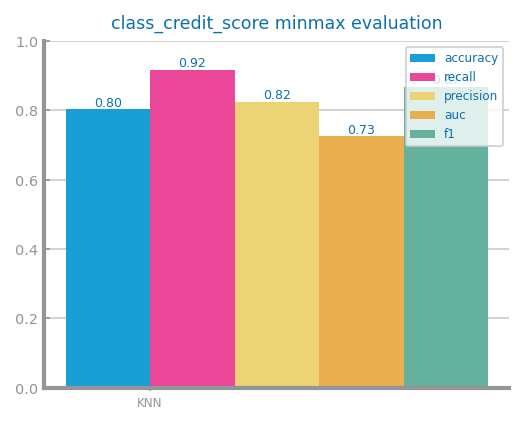

In [20]:
def evaluate_knn(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    #eval_NB: dict[str, float] | None = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] | None = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = eval_KNN[met]
    return eval

target = 'Credit_Score'
X, y = df_minmax.loc[:, df_minmax.columns != 'Credit_Score'], df_minmax['Credit_Score']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)
print(Xtrain.shape, Ytrain.shape, train.shape)

figure()
eval: dict[str, list] = evaluate_knn(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["KNN"], eval, title=f"{file_tag} minmax evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/scaling/minmax.png")
show()

### NO SCALING

In [21]:
from sklearn.preprocessing import MinMaxScaler
import shutil

file = "class_credit_score"
source_file = 'data/class_credit_score/data_preparation/outliers/replacing_outliers.csv'
destination_file = 'data/class_credit_score/data_preparation/scaling/no_scaling.csv'

shutil.copyfile(source_file, destination_file)

data : DataFrame = read_csv(destination_file)
df = data.copy(deep=True)

(62136, 31) (62136,) (62136, 32)


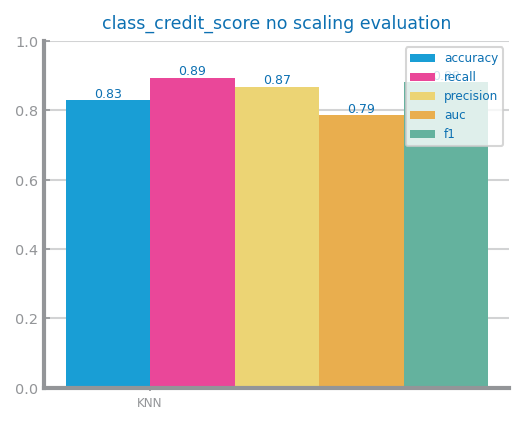

In [22]:
def evaluate_knn(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    #eval_NB: dict[str, float] | None = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] | None = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = eval_KNN[met]
    return eval

target = 'Credit_Score'
X, y = df.loc[:, df.columns != 'Credit_Score'], df['Credit_Score']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)
print(Xtrain.shape, Ytrain.shape, train.shape)

figure()
eval: dict[str, list] = evaluate_knn(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["KNN"], eval, title=f"{file_tag} no scaling evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/scaling/no_scaling.png")
show()

### COMPARE ORIGINAL TO ZSCORE AND MINMAX

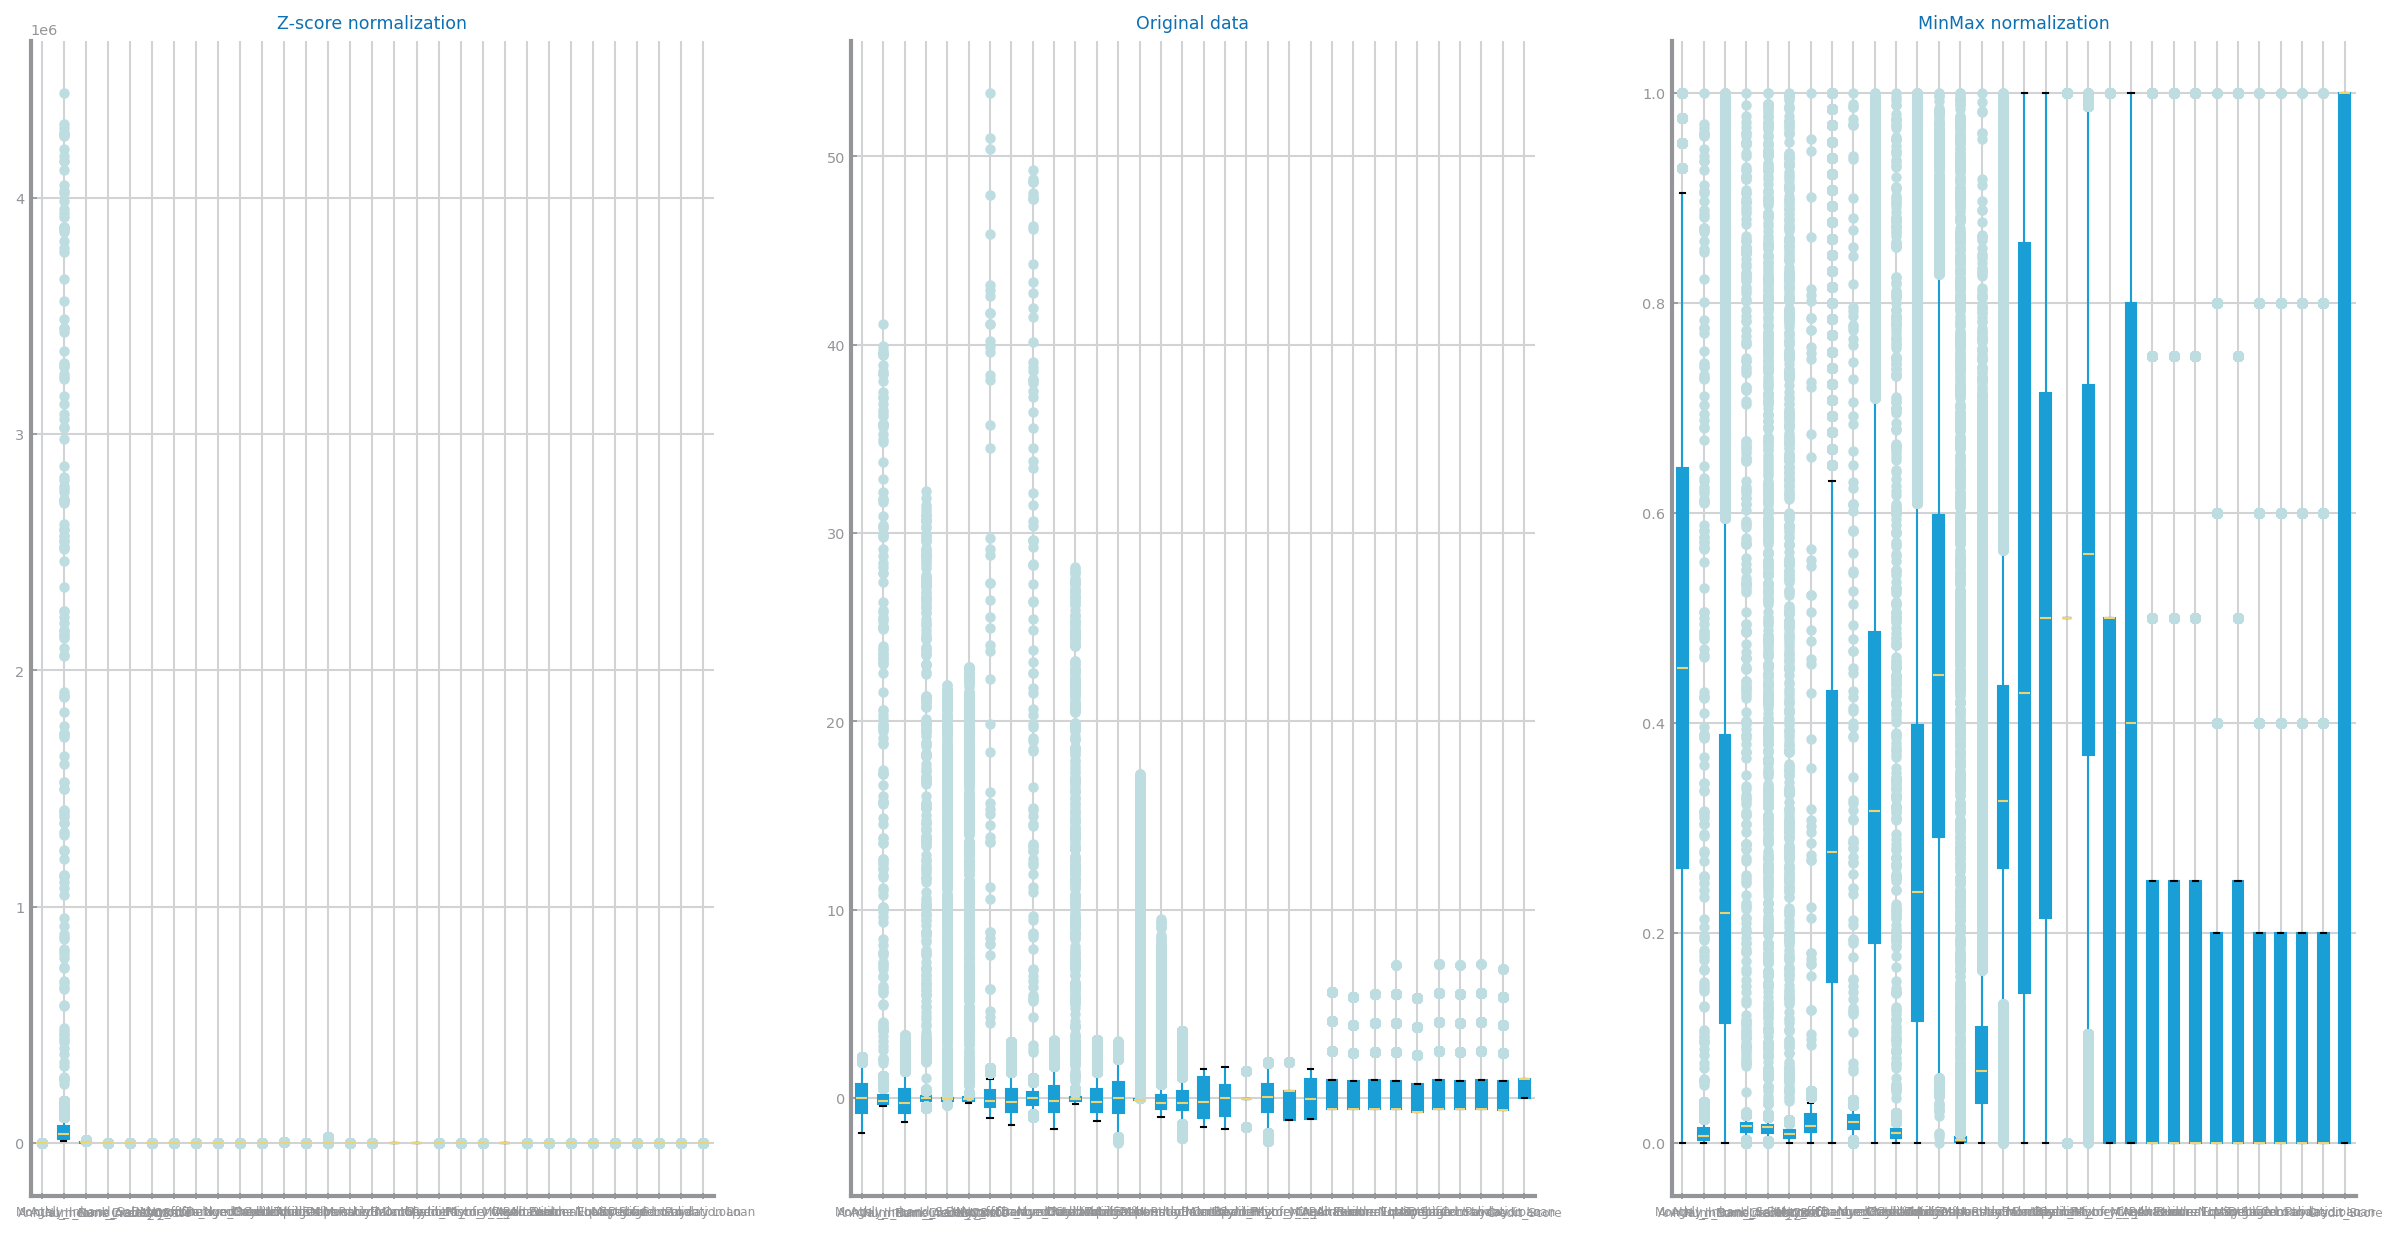

In [23]:
from matplotlib.pyplot import subplots, show

file = "class_credit_score"
data : DataFrame = read_csv('data/class_credit_score/data_preparation/outliers/replacing_outliers.csv')

target = "Credit_Score"
vars: list[str] = data.columns.to_list()
target_data: Series = data.pop(target)

fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 1].set_title("Original data")
data.boxplot(ax=axs[0, 0])
axs[0, 0].set_title("Z-score normalization")
df_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
df_minmax.boxplot(ax=axs[0, 2])
show()

# BALANCING

{'NB': [0.7607907204705113,
  0.7607907204705113,
  0.7607907204705113,
  0.7607907204705113,
  0.7607907204705113,
  0.7607907204705113,
  0.7607907204705113,
  0.7607907204705113,
  0.759483744486195,
  0.7594183956869792,
  0.7594183956869792,
  0.7594183956869792,
  0.7594183956869792,
  0.7594183956869792,
  0.7594183956869792,
  0.7594183956869792,
  0.7594183956869792,
  0.7594183956869792,
  0.7594183956869792,
  0.7594183956869792],
 'KNN': [0.8353537003757556,
  0.8353537003757556,
  0.8353537003757556,
  0.8353537003757556,
  0.8353537003757556,
  0.8353537003757556,
  0.8353537003757556,
  0.8353537003757556,
  0.8353210259761477,
  0.8353210259761477,
  0.8353210259761477,
  0.8353210259761477,
  0.8353210259761477,
  0.8353210259761477,
  0.8353210259761477,
  0.8353210259761477,
  0.8353210259761477,
  0.8353210259761477,
  0.8353210259761477,
  0.8353210259761477]}

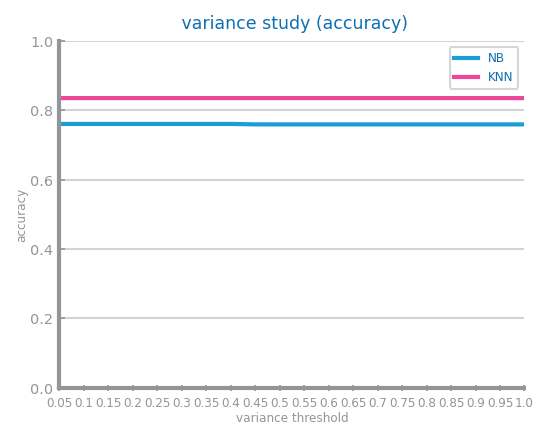

In [24]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslab_functions import plot_bar_chart, study_variance_for_feature_selection, study_redundancy_for_feature_selection

file = "class_credit_score"
target = "Credit_Score"
original: DataFrame = read_csv('data/class_credit_score/data_preparation/scaling/no_scaling.csv')

X, y = original.loc[:, original.columns != target], original[target]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)

study_variance_for_feature_selection(train, test, target, 1, 0.05, "accuracy", "")

{'NB': [0.7607907204705113], 'KNN': [0.8353537003757556]}

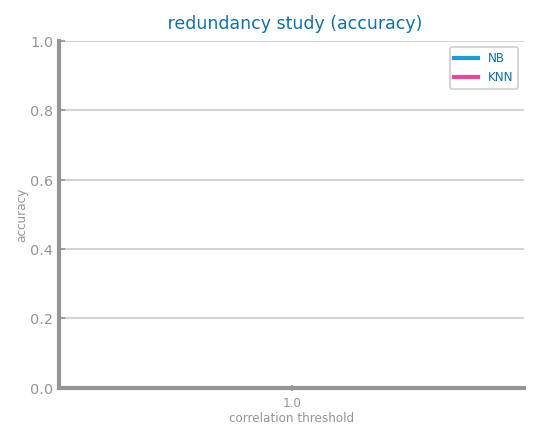

In [25]:
study_redundancy_for_feature_selection(train, test, target, 1, 0.05, "accuracy", "")

In [26]:
from dslab_functions import select_redundant_variables
data = original.copy(deep=True)
redudant_vars = select_redundant_variables(data, 0.9, target)
print(redudant_vars)

[]


In [27]:
from dslab_functions import select_low_variance_variables
data2 = original.copy(deep=True)
lowvar_vars = select_low_variance_variables(data2, 0.9, target)
print(lowvar_vars)

['CreditMix', 'Payment_of_Min_Amount', 'Auto Loan', 'Credit-Builder Loan', 'Personal Loan', 'Home Equity Loan', 'Not Specified', 'Mortgage Loan', 'Student Loan', 'Debt Consolidation Loan', 'Payday Loan']


Minority class= 0 : 27301
Majority class= 1 : 65440
Proportion: 0.42 : 1


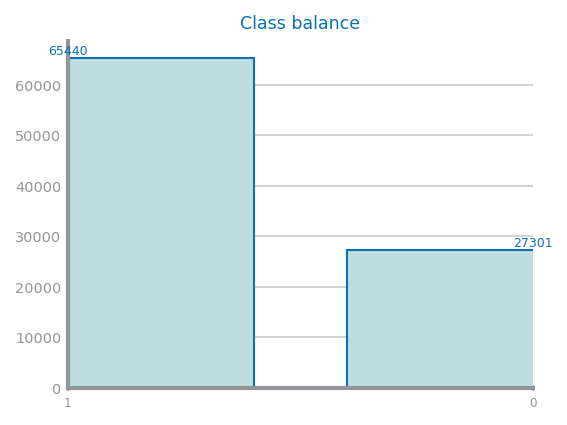

In [28]:
target_count: Series = original[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(target_count.index.to_list(), target_count.to_list(), title="Class balance")
savefig(f"images/{file_tag}/data_preparation/balancing/class_balance.png")
show()

In [29]:
df_positives: Series = original[original[target] == positive_class]
df_negatives: Series = original[original[target] == negative_class]

### UNDERSAMPLING

In [30]:
df_neg_sample: DataFrame = DataFrame(df_negatives.sample(len(df_positives)))
df_under: DataFrame = concat([df_positives, df_neg_sample], axis=0)
df_under.to_csv(f"data/{file}/data_preparation/balancing/undersampling.csv", index=False)

print("Minority class=", positive_class, ":", len(df_positives))
print("Majority class=", negative_class, ":", len(df_neg_sample))
print("Proportion:", round(len(df_positives) / len(df_neg_sample), 2), ": 1")

Minority class= 0 : 27301
Majority class= 1 : 27301
Proportion: 1.0 : 1


(36583, 31) (36583,) (36583, 32)


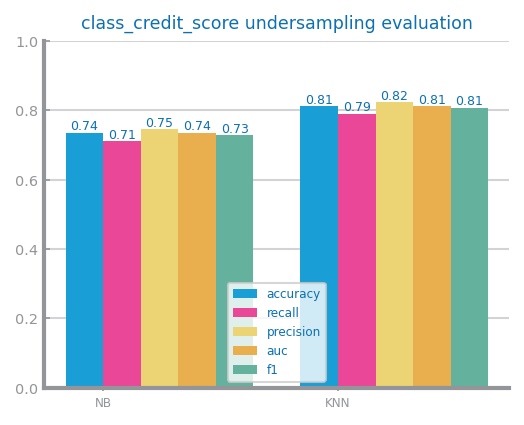

In [31]:
target = 'Credit_Score'
X, y = df_under.loc[:, df_under.columns != 'Credit_Score'], df_under['Credit_Score']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)
print(Xtrain.shape, Ytrain.shape, train.shape)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} undersampling evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/balancing/undersampling.png")
show()

### OVERSAMPLING

In [32]:
df_pos_sample: DataFrame = DataFrame(
    df_positives.sample(len(df_negatives), replace=True)
)
df_over: DataFrame = concat([df_pos_sample, df_negatives], axis=0)
df_over.to_csv(f"data/{file}/data_preparation/balancing/oversampling.csv", index=False)

print("Minority class=", positive_class, ":", len(df_pos_sample))
print("Majority class=", negative_class, ":", len(df_negatives))
print("Proportion:", round(len(df_pos_sample) / len(df_negatives), 2), ": 1")

Minority class= 0 : 65440
Majority class= 1 : 65440
Proportion: 1.0 : 1


(87689, 31) (87689,) (87689, 32)


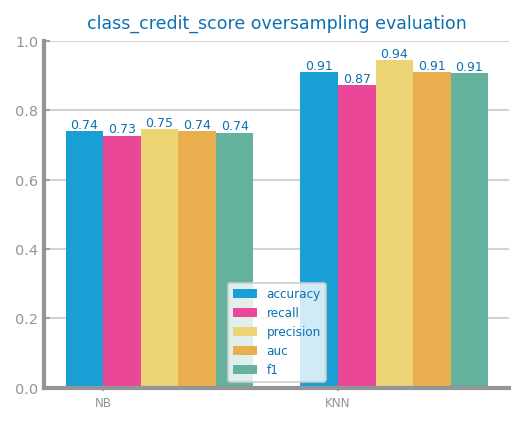

In [33]:
target = 'Credit_Score'
X, y = df_over.loc[:, df_over.columns != 'Credit_Score'], df_over['Credit_Score']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)
print(Xtrain.shape, Ytrain.shape, train.shape)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} oversampling evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/balancing/oversampling.png")
show()

### SMOTE

In [34]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
y = original.pop(target).values
X: ndarray = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote: DataFrame = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [target]
df_smote.to_csv(f"data/{file}/data_preparation/balancing/smote.csv", index=False)

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)

Minority class= 0 : 65440
Majority class= 1 : 65440
Proportion: 1.0 : 1
(130880, 32)


(87689, 31) (87689,) (87689, 32)


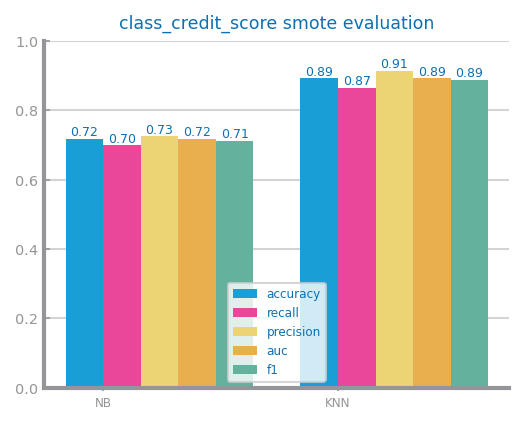

In [35]:
target = 'Credit_Score'
X, y = df_smote.loc[:, df_smote.columns != 'Credit_Score'], df_smote['Credit_Score']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)
print(Xtrain.shape, Ytrain.shape, train.shape)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} smote evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/balancing/smote.png")
show()